# Capstone project notebook:
## Forecasting AirBnb revenues in Geneva 
### The problem 
AirBnb is one of the most used renting platforms in the world and serves as a way to rent cheaply some short accomodation rooms or houses.
An owner of a set of appartment might want to get some information about how to improve its renting park and to have a clear vision on how its appartments are evaluated. 
Furthermore somebody might want to guess the price for a new set of apartment he/she wants to rent.
The municipality of a city might also want to have a clear understading of how AibBnb can impact the local renting tariffs and the values from more traditional sources 

### The datasets

The datasets used in this project come mainly from three sources
- A set of data from AIBNB allowing to see several quantities for a given municipality http://insideairbnb.com/get-the-data.html. In this project we will chose the city of Geneva in Switzerland. 
    - Data are mainly regarding types of appartments and propriety
    - Data about reviews are used
    - Data about geneva neighborhoods are used as well 
- Geopy will be used as a service to find accurate positions
- Foursquare API is used to retrieve information about the venues close to the houses, as showed in the course.

### The idea 
Several tasks will be performed: 
- A starting point is the analysis of the datasets and its cleaning
- Deescriptive analysis is performed 
- A forecasting model is done using a RandomForestRegressor 
- Starting from data at the NPA level venues close to houses are retrieved and considerations are made 
- Neighborhoods are clustered to give an additional predictor 
- Results are discussed  


In [34]:
import pandas as pd
import geopandas as gpd
import numpy as np

import folium
import codecs 
import requests
from bs4 import BeautifulSoup
import json
from geopy.geocoders import Nominatim 
from geopy.distance import geodesic
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split, KFold, validation_curve, learning_curve
from sklearn.ensemble        import RandomForestRegressor, GradientBoostingRegressor

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition           import PCA
from sklearn.model_selection         import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.impute          import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, validation_curve, learning_curve
from sklearn.ensemble        import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy           import DummyRegressor
from sklearn.metrics         import mean_squared_error
from sklearn.linear_model    import Ridge, Lasso
from sklearn.preprocessing   import StandardScaler
from sklearn.pipeline        import Pipeline
from math                    import sqrt


from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from shapely.geometry import Point 
from geopy import distance

import seaborn as sns
import os
pd.set_option('display.max_rows', 1000, 'display.max_columns', 200)

In [35]:
print('Hello Capstone project Course')

Hello Capstone project Course


# Part One: Importing the datasets

### Listings 

In [36]:
ge_listings=pd.read_csv('http://data.insideairbnb.com/switzerland/geneva/geneva/2019-08-29/data/listings.csv.gz',compression='gzip')
print('Shape',ge_listings.shape)

Shape (3212, 106)


In [37]:
print('Shape',ge_listings.shape)
print(ge_listings.isnull().sum())

Shape (3212, 106)
id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
name                                               4
summary                                          143
space                                           1273
description                                       76
experiences_offered                                0
neighborhood_overview                           1425
notes                                           2251
transit                                         1324
access                                          1782
interaction                                     1706
house_rules                                     1679
thumbnail_url                                   3212
medium_url                                      3212
picture_url                                        0
xl_picture_url              

In [38]:
ge_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,42515,https://www.airbnb.com/rooms/42515,20190829055449,2019-08-29,Geneva center - Hosting females,NaN,This is a private room with own half bath ( si...,This is a private room with own half bath ( si...,none,NaN,NaN,NaN,NaN,NaN,"I would like to take our shoes off, hence a pa...",NaN,NaN,https://a0.muscache.com/im/pictures/10640277/f...,NaN,185647,https://www.airbnb.com/users/show/185647,Noelle,2010-07-30,"Geneva, Geneva, Switzerland","Hi, I am a Management consultant professional,...",within a few hours,90%,NaN,t,https://a0.muscache.com/im/users/185647/profil...,https://a0.muscache.com/im/users/185647/profil...,NaN,1,1,"['email', 'phone', 'reviews', 'offline_governm...",t,f,"Geneva, Canton of Geneva, Switzerland",NaN,Commune de Genève,NaN,Geneva,Canton of Geneva,1207.0,Geneva,"Geneva, Switzerland",CH,Switzerland,46.20140,6.15507,f,Apartment,Private room,1,1.5,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",861.0,$98.00,$589.00,"$2,159.00",NaN,$60.00,1,$80.00,3,365,3,3,365,365,3.0,365.0,today,t,4,30,60,335,2019-08-29,50,18,2011-09-24,2019-07-27,93.0,9.0,9.0,10.0,10.0,10.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.52
1,44959,https://www.airbnb.com/rooms/44959,20190829055449,2019-08-29,Perfect Cozy Bedroom Close to Lake & Transport,Perfect for the single traveler whether it be ...,You will be staying in a cozy bedroom with a s...,Perfect for the single traveler whether it be ...,none,The apartment is situated in the heart of Gene...,NaN,"There are two direct buses going downtown, to ...","You will have access to the kitchen, bathrooms...",I will be staying with you in the apartment so...,A couple of points: - no smoking (I'm on the g...,NaN,NaN,https://a0.muscache.com/im/pictures/3340619/13...,NaN,198343,https://www.airbnb.com/users/show/198343,Rita,2010-08-11,"Geneva, Geneva, Switzerland","In Geneva by way of Istanbul, Santiago, Lagos,...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/e5ab647a-d...,https://a0.muscache.com/im/pictures/e5ab647a-d...,NaN,2,2,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Geneva, Switzerland",NaN,Commune de Genève,NaN,Geneva,NaN,1208.0,Geneva,"Geneva, Switzerland",CH,Switzerland,46.19704,6.16076,t,Apartment,Private room,1,1.5,1.

In [39]:
ge_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

In [40]:
nulls=ge_listings.isnull().sum()
nulls.sort_values(ascending=False)

neighbourhood_group_cleansed                    3212
neighbourhood                                   3212
host_acceptance_rate                            3212
license                                         3212
medium_url                                      3212
thumbnail_url                                   3212
xl_picture_url                                  3212
square_feet                                     3185
jurisdiction_names                              3179
host_neighbourhood                              3069
monthly_price                                   2904
weekly_price                                    2820
notes                                           2251
access                                          1782
interaction                                     1706
house_rules                                     1679
host_about                                      1539
neighborhood_overview                           1425
security_deposit                              

### Drop all columns with too many missing numbers

In [41]:
to_eliminate=nulls[nulls>750].index
to_eliminate

Index(['space', 'neighborhood_overview', 'notes', 'transit', 'access',
       'interaction', 'house_rules', 'thumbnail_url', 'medium_url',
       'xl_picture_url', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood',
       'neighbourhood', 'neighbourhood_group_cleansed', 'square_feet',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'license', 'jurisdiction_names'],
      dtype='object')

In [42]:
ge_listings.drop(columns=to_eliminate,inplace=True)


In [43]:
ge_listings.shape

(3212, 82)

In [44]:
len(ge_listings.id.unique())

3212

In [45]:
ge_listings.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3212.0,2.104527e+07,1.098759e+07,4.251500e+04,1.209740e+07,2.157484e+07,3.097850e+07,3.813259e+07
scrape_id,3212.0,2.019083e+13,8.595088e-01,2.019083e+13,2.019083e+13,2.019083e+13,2.019083e+13,2.019083e+13
host_id,3212.0,6.710286e+07,7.743855e+07,4.940000e+03,9.785768e+06,3.314770e+07,9.765362e+07,2.895624e+08
host_listings_count,3212.0,7.640411e+00,2.631537e+01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.550000e+02
host_total_listings_count,3212.0,7.640411e+00,2.631537e+01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.550000e+02
zipcode,3116.0,1.891337e+03,7.009722e+03,1.201000e+03,1.202000e+03,1.205000e+03,1.214000e+03,7.458000e+04
latitude,3212.0,4.620603e+01,1.902929e-02,4.613695e+01,4.619661e+01,4.620466e+01,4.621217e+01,4.635333e+01
longitude,3212.0,6.142439e+00,2.634702e-02,5.983400e+00,6.131767e+00,6.142970e+00,6.153800e+00,6.267920e+00
accommodates,3212.0,2.747821e+00,1.578797e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.500000e+01
bathrooms,3211.0,1.201651e+00,4.635234e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00


### Drop the null values 

In [46]:
ge_listings= ge_listings.dropna()
print('Test1 shapes',ge_listings.shape)

Test1 shapes (2321, 82)


In [47]:
ge_listings.isnull().sum().sum()

0

### After having dropped the null values we get to a good dataset of 2321 lines


### Enrich the NPA postal numbers 

In [48]:
zips=ge_listings.zipcode.value_counts()
print('We have in the dataset',zips.shape,'NPAs, an example is',zips.index[0])

We have in the dataset (56,) NPAs, an example is 1201.0


Unfortunately we cant go much further with this scenario but what we might do is to use the neigbourhoods in the next dataframe.

### Data about Calendar

In [49]:
ge_calendar=pd.read_csv('http://data.insideairbnb.com/switzerland/geneva/geneva/2019-08-29/data/calendar.csv.gz',compression='gzip')
print('Shape',ge_calendar.shape)
print(ge_calendar.isnull().sum())
ge_calendar.head()

Shape (1172354, 7)
listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,626512,2019-08-29,f,$140.00,$140.00,15,1120
1,626512,2019-08-30,f,$140.00,$140.00,15,1120
2,626512,2019-08-31,f,$140.00,$140.00,15,1120
3,626512,2019-09-01,f,$140.00,$140.00,15,1120
4,626512,2019-09-02,f,$140.00,$140.00,15,1120


In [50]:
mapping={'f':1.0,'t':0.0}
ge_calendar.replace({'available': mapping },inplace=True)
ge_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,626512,2019-08-29,1.0,$140.00,$140.00,15,1120
1,626512,2019-08-30,1.0,$140.00,$140.00,15,1120
2,626512,2019-08-31,1.0,$140.00,$140.00,15,1120
3,626512,2019-09-01,1.0,$140.00,$140.00,15,1120
4,626512,2019-09-02,1.0,$140.00,$140.00,15,1120


In [51]:
aggregated_calendar=ge_calendar.groupby('listing_id').sum().reset_index()

In [52]:
aggregated_calendar.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
listing_id,3212.0,2.104527e+07,1.098759e+07,42515.0,12097403.75,21574844.5,30978504.25,3.813259e+07
available,3212.0,2.504054e+02,1.340169e+02,0.0,125.00,312.5,365.00,3.650000e+02
minimum_nights,3212.0,3.164726e+03,6.486129e+04,365.0,365.00,730.0,1460.00,3.650000e+06
maximum_nights,3212.0,2.442780e+08,1.383040e+10,365.0,10950.00,410625.0,410625.00,7.838315e+11


### Data on Reviews 

In [54]:
ge_reviews=pd.read_csv('http://data.insideairbnb.com/switzerland/geneva/geneva/2019-08-29/data/reviews.csv.gz',compression='gzip')
print('Shape',ge_reviews.shape)
print(ge_reviews.isnull().sum())
ge_reviews.head()

Shape (64034, 6)
listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         25
dtype: int64


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,42515,563807,2011-09-24,997025,Dounia,"Croix is a wonderful host, very cheerful and w..."
1,42515,1296837,2012-05-17,2348546,D Corinne,This was an ideal place to stay and Croix made...
2,42515,1358497,2012-05-27,2346980,Natalia,I went to Geneva for a one week training and s...
3,42515,2365282,2012-09-21,3503874,Ela,Spent a few days with Croix and she is an abso...
4,42515,3580013,2013-02-19,4185464,Nitin,"Noelle is a fantastic host, she made me feel a..."


In [55]:
ge_reviews.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
listing_id,64034,NaN,NaN,NaN,1.44602e+07,9.58951e+06,42515,6.12577e+06,1.40406e+07,2.12518e+07,3.81256e+07
id,64034,NaN,NaN,NaN,2.68072e+08,1.47278e+08,107666,1.46242e+08,2.63489e+08,4.14917e+08,5.19497e+08
date,64034,2448,2019-03-17,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewer_id,64034,NaN,NaN,NaN,7.60921e+07,7.03289e+07,1026,1.88007e+07,5.15284e+07,1.19485e+08,2.88912e+08
reviewer_name,64034,16584,David,519,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comments,64009,61884,The host canceled this reservation 3 days befo...,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Neighbourhoods

In [251]:
ge_neigh=gpd.read_file('http://data.insideairbnb.com/switzerland/geneva/geneva/2019-08-29/visualisations/neighbourhoods.geojson')

In [252]:
print(ge_neigh.shape)
ge_neigh.head()

(45, 3)


,neighbourhood,neighbourhood_group,geometry
0,Plan-les-Ouates,None,"(POLYGON ((6.140374 46.167046, 6.140374 46.167..."
1,Lancy,None,"(POLYGON ((6.127635 46.187381, 6.127678 46.187..."
2,Meinier,None,"(POLYGON ((6.246456 46.226625, 6.246225 46.226..."
3,Carouge,None,"(POLYGON ((6.141018 46.173431, 6.141017 46.173..."
4,Aire-la-Ville,None,"(POLYGON ((6.031815 46.199169, 6.03182 46.1991..."


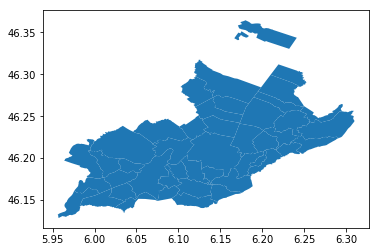

In [237]:
ge_neigh.plot()

In [253]:
## Get the center from a poligon 
ge_neigh['center_x']=[ge_neigh['geometry'][i].centroid.x for i in ge_neigh.index]
ge_neigh['center_y']=[ge_neigh['geometry'][i].centroid.y for i in ge_neigh.index]
ge_neigh.head()

,neighbourhood,neighbourhood_group,geometry,center_x,center_y
0,Plan-les-Ouates,None,"(POLYGON ((6.140374 46.167046, 6.140374 46.167...",6.119057,46.163930
1,Lancy,None,"(POLYGON ((6.127635 46.187381, 6.127678 46.187...",6.119612,46.184896
2,Meinier,None,"(POLYGON ((6.246456 46.226625, 6.246225 46.226...",6.235095,46.243001
3,Carouge,None,"(POLYGON ((6.141018 46.173431, 6.141017 46.173...",6.140353,46.181673
4,Aire-la-Ville,None,"(POLYGON ((6.031815 46.199169, 6.03182 46.1991...",6.042232,46.190231


In [254]:
ge_neigh.drop(columns=['neighbourhood_group'],inplace=True)

In [255]:
ge_neigh.head()

,neighbourhood,geometry,center_x,center_y
0,Plan-les-Ouates,"(POLYGON ((6.140374 46.167046, 6.140374 46.167...",6.119057,46.163930
1,Lancy,"(POLYGON ((6.127635 46.187381, 6.127678 46.187...",6.119612,46.184896
2,Meinier,"(POLYGON ((6.246456 46.226625, 6.246225 46.226...",6.235095,46.243001
3,Carouge,"(POLYGON ((6.141018 46.173431, 6.141017 46.173...",6.140353,46.181673
4,Aire-la-Ville,"(POLYGON ((6.031815 46.199169, 6.03182 46.1991...",6.042232,46.190231


### Adding the center of the neighborhood to each listing 

In [256]:
print(ge_neigh['geometry'][1].centroid)

POINT (6.119611854035187 46.18489626338514)


In [257]:
a=Point(6.10,46.19)

In [258]:
ge_listings['neigh']='0'

In [259]:
cc=[]
for i in ge_listings.index:
    try:
        a=Point(ge_listings.iloc[i].longitude,ge_listings.iloc[i].latitude)
        cc.append( str(ge_neigh['neighbourhood'][ge_neigh['geometry'].contains(a)==True].values)[2:-2])
    except:
        cc.append('nan')

In [260]:
ge_listings['neigh']=cc

## MERGING the Datasets

In [67]:
### Merge the listings with the neighbourhoods 
df = ge_listings.merge(ge_neigh,left_on='neigh',right_on='neighbourhood',how='left')
print(df.shape)

(2321, 87)


In [68]:
## Compute the distance of each venue from the center of geneva 
GE= (46.3,6.15)
venue=0
dist=[]
for i in df.index:
    #print(df.iloc[i].latitude,df.iloc[i].longitude)
    venue=(df.iloc[i].latitude,df.iloc[i].longitude)
    dist.append(geodesic(GE,venue).km)

In [69]:
#CREATE The distance feature 
df['distance']=dist


C:\Users\Patrizio\.conda\envs\AC36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of distance from center')

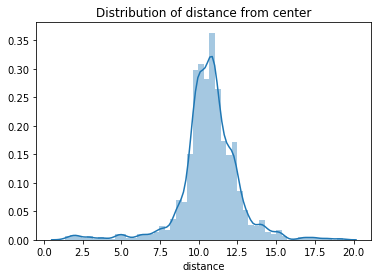

In [70]:
sns.distplot(df.distance)
plt.title('Distribution of distance from center')

#### Merge the other dataset with occupancy 

In [71]:
print(df.shape,'Before')
df=df.merge(aggregated_calendar,left_on='id',right_on='listing_id',copy=False)
print(df.shape,'after')
df.head()

(2321, 88) Before
(2321, 92) after


,id,listing_url,scrape_id,last_scraped,name,summary,description,experiences_offered,picture_url,host_id,host_url,host_name,host_since,host_location,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights_x,maximum_nights_x,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,neigh,neighbourhood,geometry,center_x,center_y,distance,listing_id,available,minimum_nights_y,maximum_nights_y
0,107438,https://www.airbnb.com/rooms/107438,20190829055449,2019-08-29,Room in an amazingflat linked to UN,Cosy place for lady located in a quiet neighbo...,Version Française et Anglaise It is a cosy fur...,none,https://a0.muscache.com/im/pictures/2032232/48...,556499,https://www.airbnb.com/users/show/556499,F. M.,2011-05-04,"Geneva, Geneva, Switzerland",f,https://a0.muscache.com/im/users/556499/profil...,https://a0.muscache.com/im/users/556499/profil...,2,2,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Geneva, Geneva, Switzerland",Commune de Genève,Geneva,Geneva,1206.0,Geneva,"Geneva, Switzerland",CH,Switzerland,46.19004,6.16014,t,Apartment,Private room,1,1.5,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",$80.00,1,$20.00,2,1125,2,2,1125,1125,2.0,1125.0,5 weeks ago,t,0,26,56,331,2019-08-29,25,4,2011-05-15,2019-07-31,97.0,10.0,9.0,9.0,9.0,9.0,9.0,f,t,f,flexible,f,f,2,1,1,0,0.25,Commune de Genève,Commune de Genève,"(POLYGON ((6.110825 46.202832, 6.110752 46.203...",6.143744,46.207076,12.247716,107438,34.0,730,410625
1,183780,https://www.airbnb.com/rooms/183780,20190829055449,2019-08-29,Beautiful room in attic appartment,Private room with private shower located in th...,Private room with private shower located in th...,none,https://a0.muscache.com/im/pictures/bf7c9742-a...,409368,https://www.airbnb.com/users/show/409368,Charles,2011-02-25,"Geneva, Geneva, Switzerland",t,https://a0.muscache.com/im/pictures/user/24952...,https://a0.muscache.com/im/pictures/user/24952...,2,2,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Geneva, Geneva, Switzerland",Commune de Genève,Geneva,Geneva,1201.0,Geneva,"Geneva, Switzerland",CH,Switzerland,46.21079,6.14702,t,Apartment,Private room,2,2.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",$90.00,2,$0.00,1,30,1,1,30,30,1.0,30.0,today,t,8,31,61,311,2019-08-29,262,72,2013-03-21,2019-08-13,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,moderate,f,f,2,1,1,0,3.34,Versoix,Versoix,"(POLYGON ((6.126449 46.316815, 6.125937 46.316...",6.156401,46.287908,9.918916,183780,54.0,365,10950
2,203997,https://www.airbnb.com/rooms/203997,20190829055449,2019-08-29,Top location studio 1 block from lake!,"Spacious studio with washer/dryer, Wi-fi, supe...","Spacious studio with washer/dryer, Wi-fi, supe...",none,https://a0.muscache.com/im/pictures/14163740/9...,1001280,https://www.airbnb.com/users/show/1001280,Mike,2011-08-21,"Geneva, Geneva, Switzerland",t,https://a0.muscache.

## Feature engineering

We shall predict the expected income per unit we shall compute the expected annual revenues:to do so we use the same idea that is reported here: 
    
    http://insideairbnb.com/geneva/?neighbourhood=&filterEntireHomes=false&filterHighlyAvailable=false&filterRecentReviews=false&filterMultiListings=false
Inside Airbnb: Geneva uses the following parameters:
- A high availability metric and filter of 60 days per year
- A frequently rented filter of 60 days per year
- A review rate of 50% for the number of guests making a booking who leave a review
- An average booking of 3 nights unless a higher minimum nights is configured for a listing.
- A maximum occupancy rate of 70% to ensure the occupancy model does not produce artifically high results based on the available data

# Selection of Predictors 

In [72]:
dict_to_keep=[
        'host_id','host_is_superhost','host_listings_count', 'host_total_listings_count',
       'zipcode', 'latitude',
       'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'price', 'guests_included', 'extra_people',
       'minimum_nights_x', 'maximum_nights_x', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
      # 'center_x', 'center_y',
       'distance', 'listing_id', 'available']

In [73]:
features=df[dict_to_keep]

In [74]:
## Cast the price as numeric 
features['price']=features.price.str.split('$',n=1,expand=True)[1]
features['extra_people']=features.extra_people.str.split('$',n=1,expand=True)[1]

C:\Users\Patrizio\.conda\envs\AC36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Patrizio\.conda\envs\AC36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
features.price.astype(float,errors='ignore')
features.extra_people.astype(float,errors='ignore')

0        20.0
1         0.0
2         0.0
3        33.0
4         0.0
5         0.0
6        45.0
7       100.0
8        40.0
9        30.0
10        0.0
11       22.0
12        0.0
13       25.0
14       20.0
15        0.0
16        0.0
17       30.0
18       30.0
19       10.0
20        0.0
21        0.0
22       15.0
23       50.0
24       54.0
25        0.0
26        0.0
27       40.0
28       33.0
29        0.0
30        0.0
31       15.0
32        0.0
33        0.0
34       50.0
35       40.0
36       70.0
37        0.0
38        5.0
39       20.0
40       35.0
41       30.0
42        0.0
43       30.0
44       60.0
45       30.0
46       10.0
47       25.0
48        0.0
49       15.0
50       60.0
51       29.0
52       30.0
53        0.0
54        0.0
55        0.0
56       50.0
57       30.0
58       25.0
59        5.0
60       25.0
61        0.0
62       20.0
63        0.0
64       10.0
65        0.0
66       30.0
67       20.0
68       20.0
69       20.0
70       50.0
71    

In [76]:
features.head()

,host_id,host_is_superhost,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,extra_people,minimum_nights_x,maximum_nights_x,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,distance,listing_id,available
0,556499,f,2,2,1206.0,46.19004,6.16014,Apartment,Private room,1,1.5,1.0,1.0,Real Bed,80.00,1,20.00,2,1125,2,2,1125,1125,2.0,1125.0,t,0,26,56,331,25,4,97.0,10.0,9.0,9.0,9.0,9.0,9.0,f,t,f,flexible,2,1,1,0,0.25,12.247716,107438,34.0
1,409368,t,2,2,1201.0,46.21079,6.14702,Apartment,Private room,2,2.0,1.0,1.0,Real Bed,90.00,2,0.00,1,30,1,1,30,30,1.0,30.0,t,8,31,61,311,262,72,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,moderate,2,1,1,0,3.34,9.918916,183780,54.0
2,1001280,t,3,3,1207.0,46.19967,6.15597,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,165.00,1,0.00,3,730,3,3,730,730,3.0,730.0,t,0,28,33,33,72,15,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,t,f,strict_14_with_grace_period,1,1,0,0,0.87,11.161799,203997,332.0
3,1442438,f,2,2,1290.0,46.27944,6.16724,Apartment,Entire home/apt,5,1.0,1.0,3.0,Real Bed,91.00,2,33.00,7,90,7,7,90,90,7.0,90.0,t,8,8,8,256,96,12,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,t,f,moderate,1,1,0,0,1.06,2.643455,276025,109.0
4,1667362,t,1,1,1201.0,46.21428,6.14610,Apartment,Entire home/apt,2,1.5,1.0,1.0,Real Bed,150.00,1,0.00,3,30,3,3,30,30,3.0,30.0,t,2,22,44,310,95,18,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,f,f,moderate,1,1,0,0,1.07,9.533065,325986,55.0


## Compute the one hot encoding for different variables 

In [77]:
## One hot encoding 

onehot= ['room_type','property_type','bed_type','cancellation_policy']

In [78]:
df_onehotencoded=pd.get_dummies(columns=onehot,data=features)

In [79]:
#Map discrete values to 1-0
mapping={'t':1.0,'f':0.0}

tomap=['host_is_superhost','has_availability','requires_license','instant_bookable','is_business_travel_ready']

[df_onehotencoded.replace({i: mapping },inplace=True) for i in tomap]

[None, None, None, None, None]

In [80]:
df_onehotencoded.astype(float,errors='ignore')
print(df_onehotencoded.shape)
df_onehotencoded.head()

(2321, 81)


,host_id,host_is_superhost,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights_x,maximum_nights_x,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,distance,listing_id,available,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,property_type_Apartment,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Loft,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tiny house,property_type_Townhouse,property_type_Villa,property_type_Yurt,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30
0,556499,0.0,2,2,1206.0,46.19004,6.16014,1,1.5,1.0,1.0,80.00,1,20.00,2,1125,2,2,1125,1125,2.0,1125.0,1,0,26,56,331,25,4,97.0,10.0,9.0,9.0,9.0,9.0,9.0,0.0,1.0,0.0,2,1,1,0,0.25,12.247716,107438,34.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,409368,1.0,2,2,1201.0,46.21079,6.14702,2,2.0,1.0,1.0,90.00,2,0.00,1,30,1,1,30,30,1.0,30.0,1,8,31,61,311,262,72,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,2,1,1,0,3.34,9.918916,183780,54.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,1001280,1.0,3,3,1207.0,46.19967,6.15597,2,1.0,1.0,1.0,165.00,1,0.00,3,730,3,3,730,730,3.0,730.0,1,0,28,33,33,72,15,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,1.0,0.0,1,1,0,0,0.87,11.161799,203997,332.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,1442438,0.0,2,2,1290.0,46.27944,6.16724,5,1.0,1.0,3.0,91.00,2,33.00,7,90,7,7,90,90,7.0,90.0,1,8,8,8,256,96,12,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0.0,1.0,0.0,1,1,0,0,1.06,2.643455,276025,109.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,1667362,1.0,1,1,1201.0,46.21428,6.14610,2,1.5,1.0,1.0,150.00,1,0.00,3,30,3,3,30,30,3.0,30.0,1,2,22,44,310,95,18,97.0,10.0,10.0,10.0,10.0,9.0,9.0,0.0,0.0,0.0,1,1,0,0,1.07,9.533065,325986,55.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [81]:
df_onehotencoded=df_onehotencoded.apply(pd.to_numeric,errors=np.nan)

In [82]:
df_onehotencoded.isnull().sum()

host_id                                            0
host_is_superhost                                  0
host_listings_count                                0
host_total_listings_count                          0
zipcode                                            0
latitude                                           0
longitude                                          0
accommodates                                       0
bathrooms                                          0
bedrooms                                           0
beds                                               0
price                                              4
guests_included                                    0
extra_people                                       0
minimum_nights_x                                   0
maximum_nights_x                                   0
minimum_minimum_nights                             0
maximum_minimum_nights                             0
minimum_maximum_nights                        

In [83]:
print(df_onehotencoded.shape,'before')
df_onehotencoded.dropna(inplace=True)
print(df_onehotencoded.shape,'after')

(2321, 81) before
(2317, 81) after


### Compute the average revenues for each listing accordin to "InsideAirBnb"

In [84]:
## The source can be found on http://insideairbnb.com/get-the-data.html
AV=0.7
MMM=12.0 
REVIEWSONTOTAL=0.5
y= AV*MMM/REVIEWSONTOTAL*df_onehotencoded.price*df_onehotencoded.reviews_per_month*df_onehotencoded.minimum_nights_avg_ntm

len(y)

2317

In [85]:
print('The maximun price is',max(df_onehotencoded.price), 'the maximum revenue is',max(y))

The maximun price is 980.0 the maximum revenue is 3124799.999999999


(0, 500000)

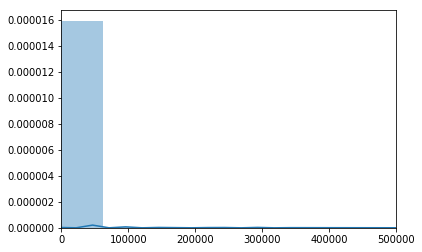

In [86]:
sns.distplot(y)
plt.xlim(0,500000)

In [104]:
df_correlation = df_onehotencoded.copy()
df_correlation['Y']=y

In [108]:
correl= df_correlation.corr()
ccc=correl['Y']*100

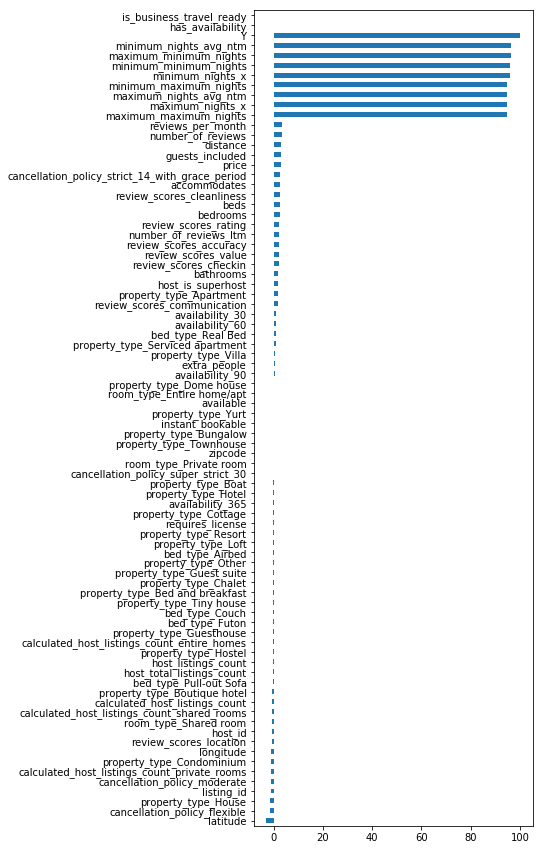

In [114]:
ccc.sort_values(ascending=True).plot.barh(figsize=(5,15))


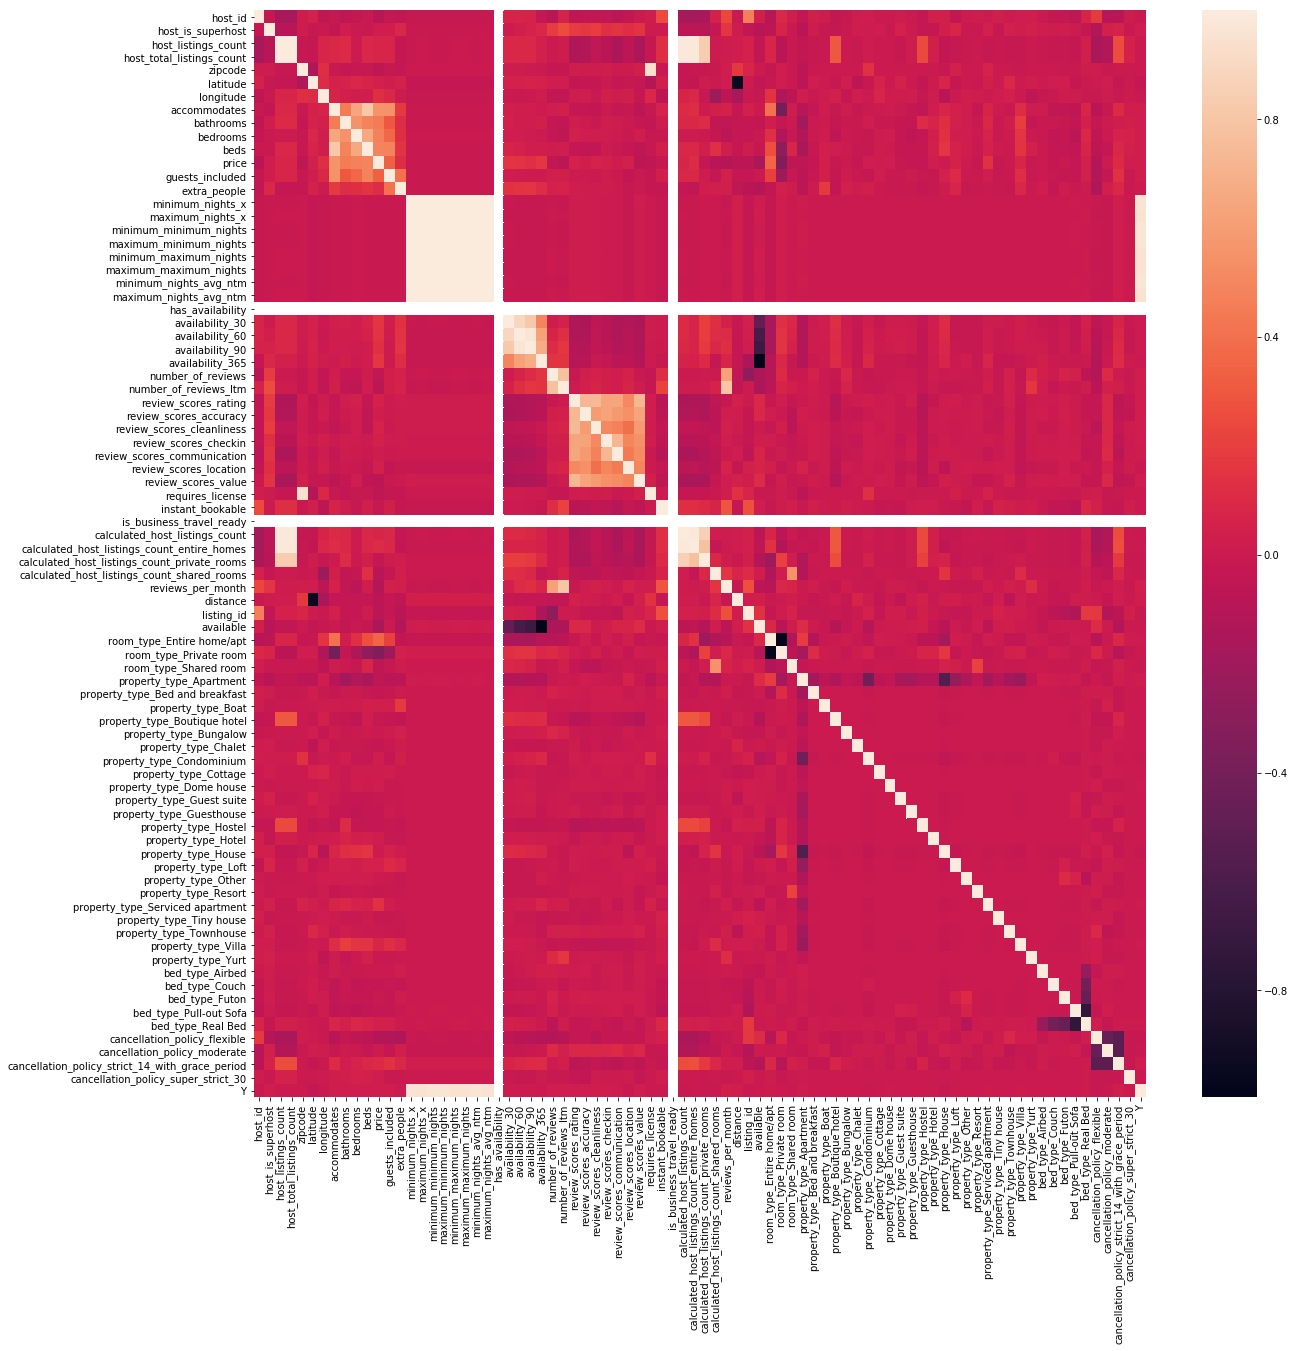

In [106]:
plt.figure(figsize=(20,20))
sns.heatmap(correl)

## Plotting

Text(0.5, 1.0, 'Venues per NPA ')

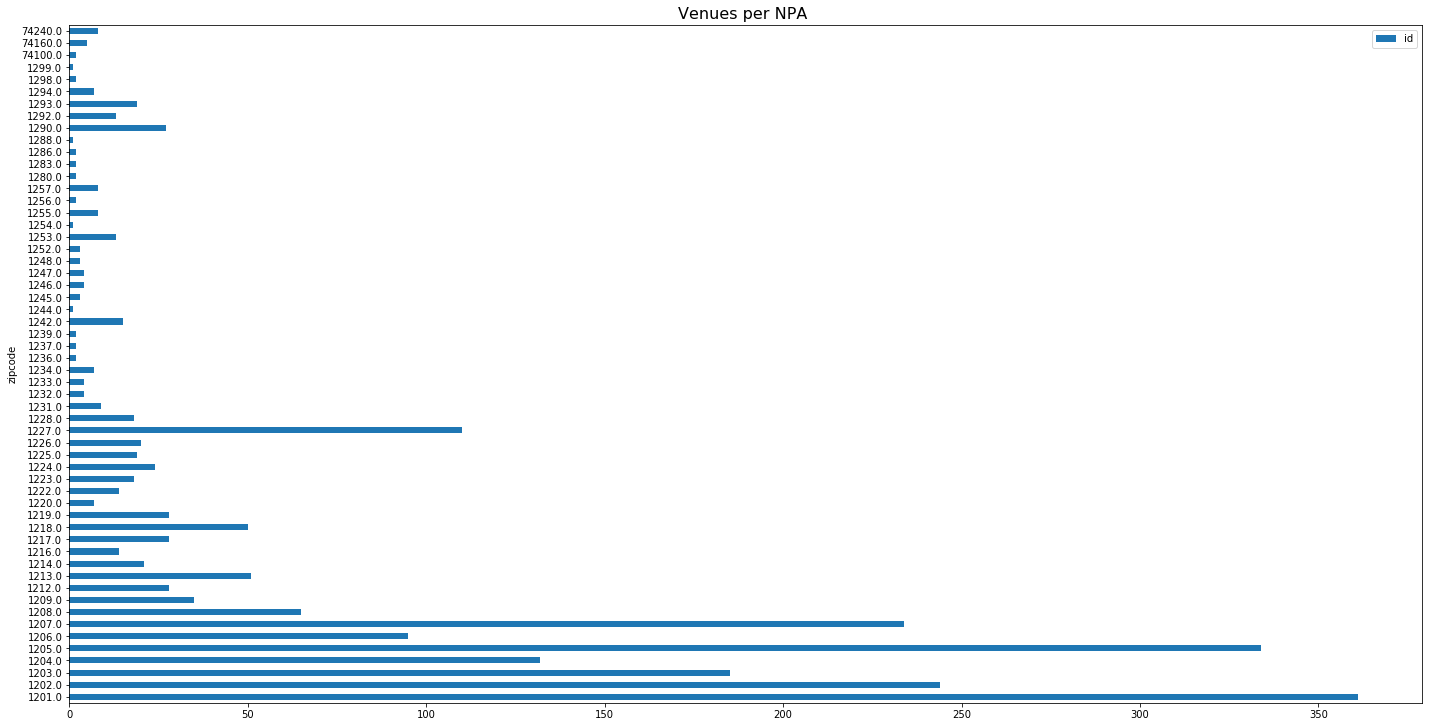

In [119]:
## Visualise how many rentable venues are present per NPA: 
df[['id','zipcode']].groupby('zipcode').count().plot.barh(figsize=(20,10))
plt.tight_layout()
plt.title('Venues per NPA ',fontsize=16)

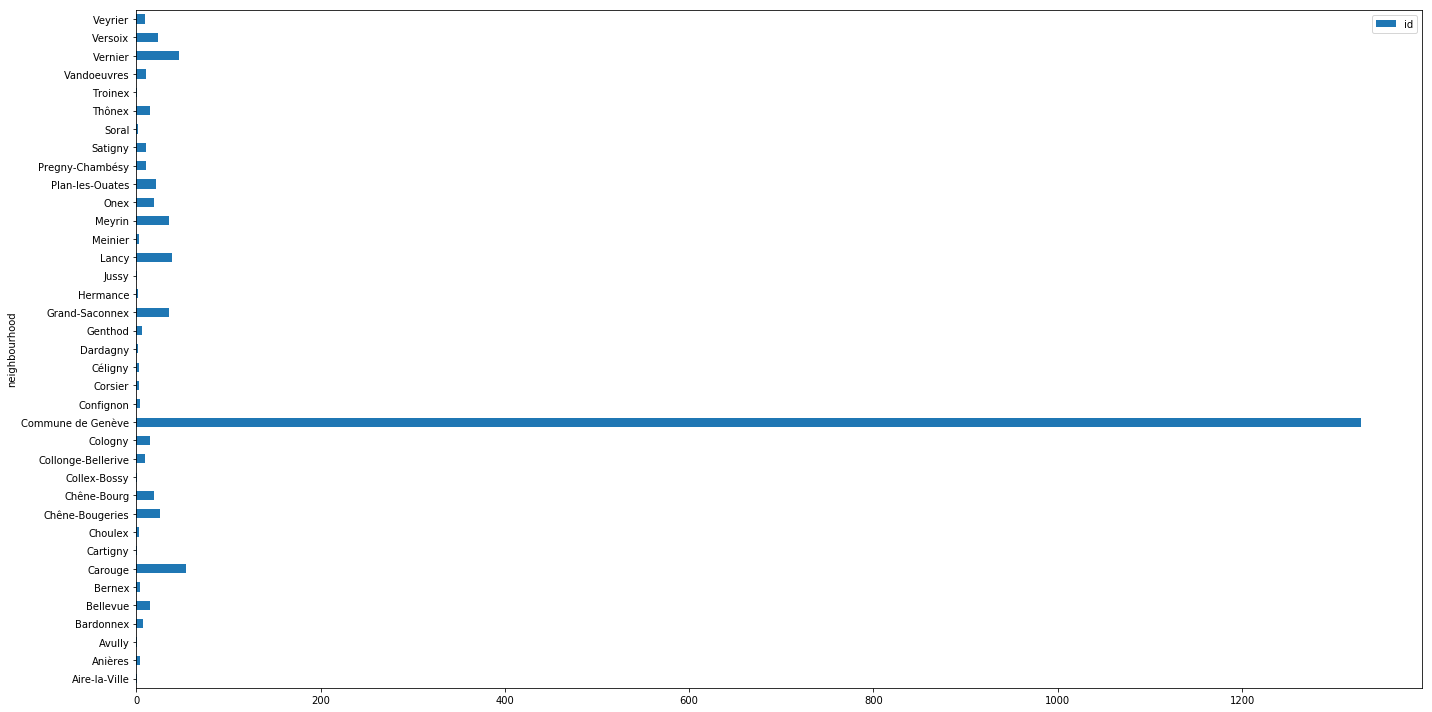

In [116]:
## Visualise how many rentable venues are present per NPA: 
df[['id','neighbourhood']].groupby('neighbourhood').count().plot.barh(figsize=(20,10))
plt.tight_layout()

Text(0.5, 1.0, 'Room Type')

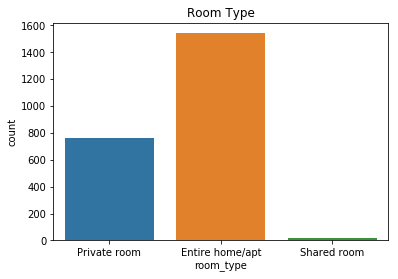

In [117]:

sns.countplot(x='room_type',data=df)
plt.title('Room Type')

In [120]:
room_types= df.room_type.unique()

In [121]:
x = np.arange(len(room_types))
ys = [i + x + (i*x)**2 for i in range(len(room_types))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [122]:
#Make a map of the existing AIRBNB in Geneva 
#make a map 

map1= folium.Map(location=[46.2, 6.15], zoom_start=12)
ge_listings_test=df[0:1000]
# set color scheme for the different typologies of rooms 
x = np.arange(len(room_types))
ys = [i + x + (i*x)**2 for i in range(len(room_types))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, price, room_type in zip(ge_listings_test['latitude'],ge_listings_test['longitude'],ge_listings_test['price'],ge_listings_test['room_type']):
    label = '{}, {}'.format(room_type,price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color=rainbow[np.where((room_type==room_types)==True)[0][0]],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map1)  
map1

In [123]:
types =['property_type_Apartment', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Cottage',
       'property_type_Dome house', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Loft',
       'property_type_Other', 'property_type_Resort',
       'property_type_Serviced apartment', 'property_type_Tiny house',
       'property_type_Townhouse', 'property_type_Villa', 'property_type_Yurt','price']

room_types=df_onehotencoded[types].sum(axis=0)

room_types.sort_values(ascending=False, inplace=True)
room_types.head(10)

price                               268039.0
property_type_Apartment               1952.0
property_type_House                    135.0
property_type_Condominium               75.0
property_type_Loft                      26.0
property_type_Villa                     22.0
property_type_Bed and breakfast         15.0
property_type_Serviced apartment        15.0
property_type_Townhouse                 15.0
property_type_Guesthouse                13.0
dtype: float64

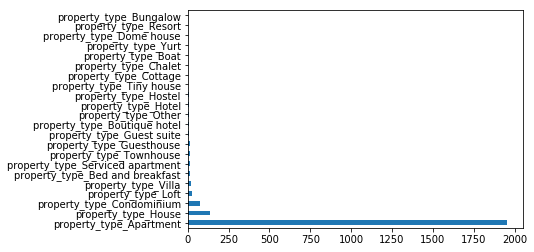

In [126]:
room_types[1:].plot.barh()

# Modeling

### Test and Train 

In [134]:
X=df_onehotencoded

 
 
#### Compute the logarithms of the quantity since the distribution is very shifted towards the high values

In [135]:
yy=np.log(y)

(0, 1000000)

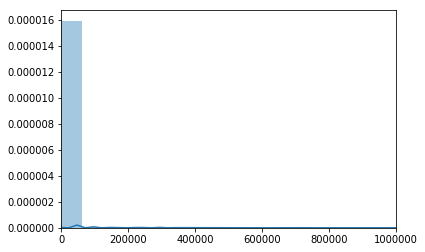

In [141]:
ax=sns.distplot(y)
ax.set_xlim(0,1000000)

Text(0.5, 1.0, 'Log Distribution of target')

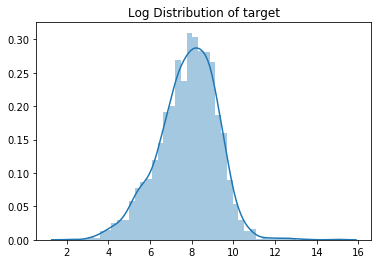

In [142]:
sns.distplot(yy)
plt.title('Log Distribution of target')

In [143]:
## apply standard scaler 
scaler=StandardScaler()
X_scaled= scaler.fit_transform(df_onehotencoded)

In [144]:
# Separaate target and features into test and training and validation sets
# Normalise data 



X_train, X_test, y_train, y_test = train_test_split(X_scaled,yy, test_size = 0.2, random_state = 23)
#X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = SEED)

print('Dimensions of training set: {}'.format(X_train.shape))

print('Dimensions of testing set: {}'.format(X_test.shape))

Dimensions of training set: (1853, 81)
Dimensions of testing set: (464, 81)


### Train a model using GridCV 

In [193]:
gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(3,7),
        'n_estimators': (10, 50, 100, 1000),
    },
    cv=5, 
    scoring='neg_mean_squared_error', 
    verbose=0,                         
    n_jobs=-1)

grid_result = gsc.fit(X, yy)
best_params = grid_result.best_params_
    
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
scores = cross_val_score(rfr, X, yy, cv=5, scoring='neg_mean_absolute_error')

In [194]:
scores

array([-0.28094171, -0.25229619, -0.25746809, -0.22047548, -0.22817324])

In [195]:
rfr.fit(X_train,y_train)
yhat=rfr.predict(X_test)

C:\Users\Patrizio\.conda\envs\AC36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


The sglobal  (MSE) 21.740353769011477 % on exponential values


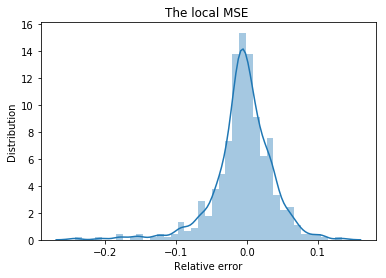

In [196]:
sns.distplot(((y_test-yhat))/(y_test))
plt.title('The local MSE ')
plt.xlabel('Relative error')
plt.ylabel('Distribution')
print('The sglobal  (MSE)',compute_exponential_score(y_test,yhat),'% on exponential values')

In [197]:
# Define a function to facilitate drawing validation curves
def plot_validation_curve(train_scores, cv_scores, x_data, scale='lin', title='', y_label='', x_label=''):

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)
    
    fig, ax = plt.subplots(figsize = (14, 8))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    lw = 2
    
    plt.fill_between(x_data, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2, color="r", lw=lw)
    plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="g", lw=lw)
    
    if (scale == 'lin'):
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
        
    elif (scale == 'log'):
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
        
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    

In [198]:
# Define all constants

SEED = 0  # base to generate a random number

# Performance metric and number of CV splits
SCORE    = 'neg_mean_squared_error'
N_SPLITS = 3

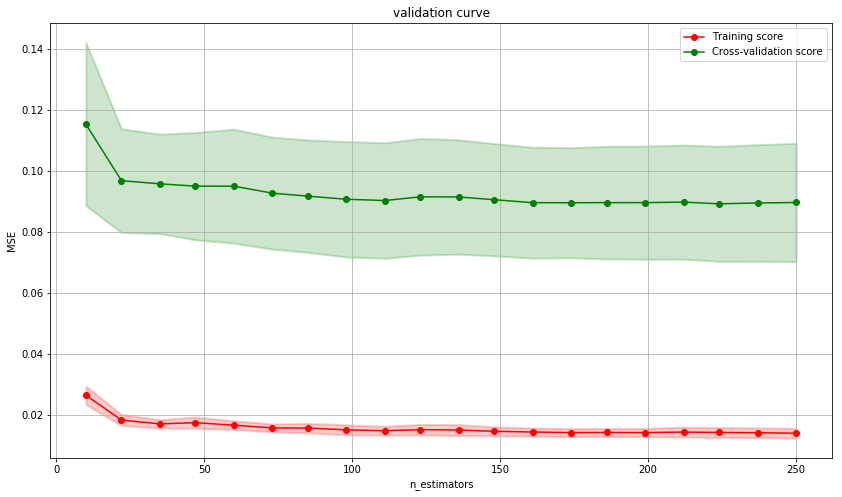

Best n_estimators: 224


In [199]:
# Define pipeline
estimators = []
estimators.append(('rf_reg', RandomForestRegressor()))

rf_pipe = Pipeline(estimators)
rf_pipe.set_params(rf_reg__random_state = SEED)

# CV schema
cv_schema = KFold(n_splits = N_SPLITS, random_state = SEED)

# Tune model against a single hyper parameter
tuning_param = 'rf_reg__n_estimators'

tuning_param_range = [int(i) for i in np.linspace(10.0, 250.0, 20)]

# Tune hyper parameter using validation curve
train_scores_val, cv_scores_val = validation_curve(
    rf_pipe, X_train, y_train, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = SCORE, n_jobs = -1)

# Draw validation curve   
plot_validation_curve(-train_scores_val, -cv_scores_val, tuning_param_range, scale = 'lin', 
                      title = 'validation curve', y_label = 'MSE', x_label = 'n_estimators')

# Obtain the best value of the hyper parameter
best_param_val = tuning_param_range[np.argmin(np.mean(-cv_scores_val, axis=1))]
print('Best n_estimators: {}'.format(best_param_val))

In [188]:
rfr = RandomForestRegressor( n_estimators=best_param_val,random_state=False, verbose=False)
rfr.fit(X_train,y_train)
yhat=rfr.predict(X_test)


In [189]:

print('The sglobal  (MSE)',compute_exponential_score(y_test,yhat),'% on exponential values')

The sglobal  (MSE) 11.117779376782385 % on exponential values


In [183]:
def compute_exponential_score(x,xhat):
    xexp=np.exp(x)
    xhatexp=np.exp(xhat)
    
    err=(xhatexp-xexp).pow(2)/xexp.pow(2)
    
    error=np.sqrt(err)
    
    glob_error= 100*np.mean(error)
    return glob_error

Text(0.5, 1.0, 'Distribution of the errors Advanced Pipeline')

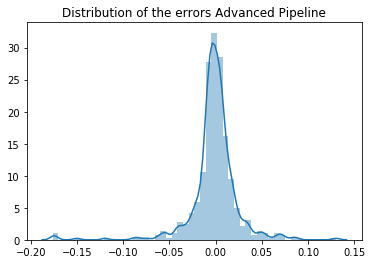

In [192]:
sns.distplot(((y_test-yhat))/(y_test))
plt.title('Distribution of the errors Advanced Pipeline')

In [159]:
importance=pd.DataFrame()
importance['Name']=X.columns
importance['Value']=rfr.feature_importances_


importance.sort_values(by='Value',ascending=False,inplace=True)

importance.head(15)

,Name,Value
43,reviews_per_month,0.560527
20,minimum_nights_avg_ntm,0.144589
11,price,0.125665
17,maximum_minimum_nights,0.067941
16,minimum_minimum_nights,0.034640
14,minimum_nights_x,0.030676
6,longitude,0.002490
0,host_id,0.002171
47,room_type_Entire home/apt,0.001828
45,listing_id,0.001741


In [163]:
importance.set_index('Name',inplace=True)

Text(0.5, 1.0, 'Most important Features')

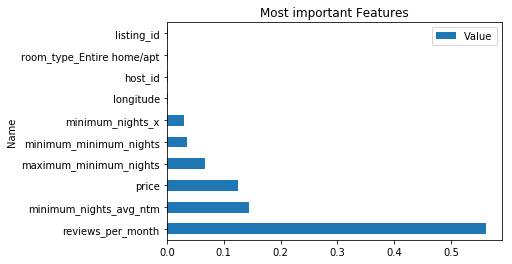

In [200]:
importance[0:10].plot.barh()
plt.title('Most important Features')

# Use the data from FourSquare to improve the quality of the modelling 


In [266]:
### Initialize the foursquare API 
CLIENT_ID = 'WX1VEFIP5VP3N41R23CXEYWHUKFWR1X5QHX2DT0T0SSGJO4Z' # your Foursquare ID
CLIENT_SECRET = 'UQP01L5J2MGOJEJ1RJC5MOZICK1KZJ5VQSDQG2ZVNTBD4E54' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentials on the foursquare API ')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentials on the foursquare API 
CLIENT_ID: WX1VEFIP5VP3N41R23CXEYWHUKFWR1X5QHX2DT0T0SSGJO4Z
CLIENT_SECRET:UQP01L5J2MGOJEJ1RJC5MOZICK1KZJ5VQSDQG2ZVNTBD4E54


In [287]:
# input to clustering 
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
         
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [288]:
geneva_venues=getNearbyVenues(names=ge_neigh.neighbourhood,
                              latitudes=ge_neigh.center_y,
                              longitudes=ge_neigh.center_x)

Plan-les-Ouates
Lancy
Meinier
Carouge
Aire-la-Ville
Avully
Avusy
Anières
Bardonnex
Bellevue
Bernex
Jussy
Cartigny
Gy
Hermance
Genthod
Grand-Saconnex
Dardagny
Commune de Genève
Confignon
Versoix
Veyrier
Thônex
Troinex
Vandoeuvres
Vernier
Perly-Certoux
Presinge
Pregny-Chambésy
Russin
Puplinge
Chêne-Bourg
Chêne-Bougeries
Laconnex
Soral
Satigny
Chancy
Céligny
Cologny
Collonge-Bellerive
Collex-Bossy
Choulex
Onex
Meyrin
Corsier


In [271]:
print(geneva_venues.shape)
geneva_venues.head()

(311, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Plan-les-Ouates,46.163930,6.119057,Entreprise Vert-Tige,46.164221,6.123180,Garden
1,Plan-les-Ouates,46.163930,6.119057,Patinoire de Plan-Les-Ouates,46.167108,6.120470,Skating Rink
2,Plan-les-Ouates,46.163930,6.119057,Le Chalet à Nico,46.167468,6.116837,Burger Joint
3,Lancy,46.184896,6.119612,Café Zinette,46.183528,6.121594,French Restaurant
4,Lancy,46.184896,6.119612,Auberge du Grand Lancy,46.183551,6.121089,Café


In [274]:
geneva_grouped=geneva_venues.groupby(geneva_venues.Neighborhood).count()

In [291]:
# one hot encoding
geneva_onehot=[]
geneva_onehot = pd.get_dummies(geneva_venues[['Venue Category']], prefix="", prefix_sep="")

print(geneva_onehot.shape, geneva_onehot.columns)

# add neighborhood column back to dataframe
geneva_onehot['Neighborhood'] = geneva_venues['Neighborhood'] 
print(geneva_onehot.shape)
print(geneva_onehot.columns)

(618, 140) Index(['Airport', 'Airport Lounge', 'Airport Service', 'Airport Terminal',
       'Asian Restaurant', 'Assisted Living', 'Athletics & Sports',
       'Auto Dealership', 'Automotive Shop', 'BBQ Joint',
       ...
       'Tourist Information Center', 'Track Stadium', 'Train Station',
       'Tram Station', 'Waterfront', 'Wine Bar', 'Wine Shop', 'Winery',
       'Women's Store', 'Yoga Studio'],
      dtype='object', length=140)
(618, 140)
Index(['Airport', 'Airport Lounge', 'Airport Service', 'Airport Terminal',
       'Asian Restaurant', 'Assisted Living', 'Athletics & Sports',
       'Auto Dealership', 'Automotive Shop', 'BBQ Joint',
       ...
       'Tourist Information Center', 'Track Stadium', 'Train Station',
       'Tram Station', 'Waterfront', 'Wine Bar', 'Wine Shop', 'Winery',
       'Women's Store', 'Yoga Studio'],
      dtype='object', length=140)


In [292]:
filters=['Neighborhood']
fixed_columns = filters + list(geneva_onehot.columns[~geneva_onehot.columns.isin( filters) ])
geneva_onehot = geneva_onehot[fixed_columns]
print('How many do we get',geneva_onehot.shape)
geneva_onehot.head()

How many do we get (618, 140)


,Neighborhood,Airport,Airport Lounge,Airport Service,Airport Terminal,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bakery,Bar,Beach,Beach Bar,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Candy Store,Car Wash,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Eastern European Restaurant,Electronics Store,Event Service,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food Truck,French Restaurant,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,General Travel,Golf Course,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,History Museum,Home Service,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kebab Restaurant,Lake,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Multiplex,Music Venue,Nightclub,Noodle House,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Real Estate Office,Rental Car Location,Restaurant,River,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Stables,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tourist Information Center,Track Stadium,Train Station,Tram Station,Waterfront,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Plan-les-Ouates,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Plan-les-Ouates,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Plan-les-Ouates,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Plan-les-Ouates,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Plan-les-Ouates,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [293]:
geneva_grouped = geneva_onehot.groupby(['Neighborhood']).mean().reset_index()
print('the shape',geneva_grouped.shape)
geneva_grouped.head()

the shape (45, 140)


,Neighborhood,Airport,Airport Lounge,Airport Service,Airport Terminal,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bakery,Bar,Beach,Beach Bar,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Candy Store,Car Wash,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Eastern European Restaurant,Electronics Store,Event Service,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food Truck,French Restaurant,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,General Travel,Golf Course,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,History Museum,Home Service,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kebab Restaurant,Lake,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Multiplex,Music Venue,Nightclub,Noodle House,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Real Estate Office,Rental Car Location,Restaurant,River,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Stables,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tourist Information Center,Track Stadium,Train Station,Tram Station,Waterfront,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Aire-la-Ville,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Anières,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Avully,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Avusy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [294]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [295]:
geneva_grouped.shape[0]

45

In [296]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = geneva_grouped['Neighborhood']

for ind in np.arange(geneva_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(geneva_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(20)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aire-la-Ville,Home Service,Restaurant,Stables,Mexican Restaurant,Lake,Yoga Studio,Eastern European Restaurant,Farmers Market,Falafel Restaurant,Event Service
1,Anières,Swiss Restaurant,French Restaurant,Plaza,Beach,Eastern European Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Service,Electronics Store
2,Avully,Diner,Chinese Restaurant,Deli / Bodega,Eastern European Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Service,Electronics Store,Yoga Studio
3,Avusy,French Restaurant,Bus Stop,Convenience Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Service,Electronics Store,Eastern European Restaurant,Discount Store
4,Bardonnex,French Restaurant,Soccer Field,History Museum,Hardware Store,Harbor / Marina,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Dessert Shop
5,Bellevue,Restaurant,Gym,Train Station,Chinese Restaurant,Mediterranean Restaurant,Spa,Seafood Restaurant,Playground,Middle Eastern Restaurant,French Restaurant
6,Bernex,Bus Station,Pool,Thai Restaurant,Diner,Yoga Studio,Farmers Market,Falafel Restaurant,Event Service,Electronics Store,Eastern European Restaurant
7,Carouge,French Restaurant,Italian Restaurant,Bar,Supermarket,Plaza,Pizza Place,Ice Cream Shop,Restaurant,Café,Construction & Landscaping
8,Cartigny,Stables,Bar,Yoga Studio,Food Truck,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Service,Electronics Store,Eastern European Restaurant
9,Chancy,Women's Store,Playground,French Restaurant,Hardware Store,Harbor / Marina,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Health & Beauty Service


### Clustering neighborhoods in geneva

len of clusters  15
len of inertia  15


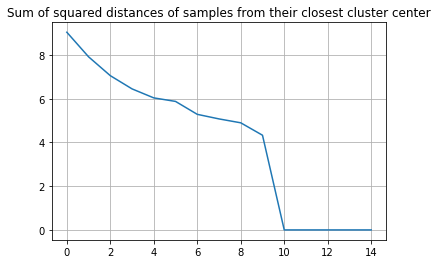

In [297]:
#choose the most efficient number of clusters 

geneva_grouped_kmeans=geneva_grouped.drop('Neighborhood',1)

clusters=np.linspace(1,10,15).astype(int)
print('len of clusters ',len(clusters))
inertia=np.zeros(len(clusters))
print('len of inertia ',len(inertia))

                                          
for kk in clusters:
    kmeans_test = KMeans(n_clusters=kk, random_state=0).fit(geneva_grouped_kmeans)
    inertia[kk-1]=kmeans_test.inertia_
plt.plot(inertia)
plt.title('Sum of squared distances of samples from their closest cluster center')
plt.grid()
    

In [298]:
 # set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(geneva_grouped_kmeans)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 


array([1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3,
       1, 0, 3, 1, 3, 1, 2, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1,
       1])

Text(0.5, 1.0, 'Number of neighborhoods in each cluster')

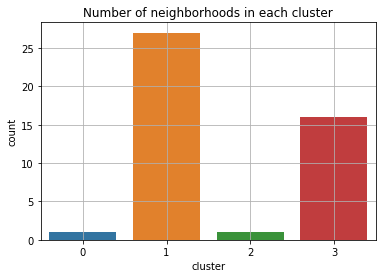

In [299]:
geneva_grouped['cluster']=kmeans.labels_

sns.countplot(x='cluster',data=geneva_grouped)
plt.grid()
plt.title('Number of neighborhoods in each cluster')

In [300]:

geneva_merged=ge_neigh.merge(geneva_grouped,left_on='neighbourhood',right_on='Neighborhood',how='left', copy=False )
geneva_merged.head()

,neighbourhood,geometry,center_x,center_y,Neighborhood,Airport,Airport Lounge,Airport Service,Airport Terminal,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bakery,Bar,Beach,Beach Bar,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Candy Store,Car Wash,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Eastern European Restaurant,Electronics Store,Event Service,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food Truck,French Restaurant,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,General Travel,Golf Course,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,History Museum,Home Service,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kebab Restaurant,Lake,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Multiplex,Music Venue,Nightclub,Noodle House,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Real Estate Office,Rental Car Location,Restaurant,River,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Stables,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tourist Information Center,Track Stadium,Train Station,Tram Station,Waterfront,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,cluster
0,Plan-les-Ouates,"(POLYGON ((6.140374 46.167046, 6.140374 46.167...",6.119057,46.163930,Plan-les-Ouates,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.076923,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.076923,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.076923,0.153846,0.0,0.0,0.0,0.153846,0.0,0.000000,0.0,0.0,0.076923,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.076923,0.000000,0.0,0.0,0.0,0.076923,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.076923,0.0,0.0,0.0,0.076923,0.0,0.000000,0.076923,0.0,0.0,0.000000,1
1,Lancy,"(POLYGON ((6.127635 46.187381, 6.127678 46.187...",6.119612,46.184896,Lancy,0.0,0.0,0.0,0.0,0.019231,0.0,0.0,0.0,0.0,0.000000,0.019231,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038462,0.019231,0.0,0.0,0.000000,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.019231,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.019231,0.019231,0.019231,0.038462,0.0,0.0,0.000000,0.038462,0.0,0.000000,0.038462,0.0,0.0,0.0,0.000000,0.0,0.019231,0.0,0.0,0.019231,0.0,0.019231,0.019231,0.0,0.000000,0.0,0.0,0.0,0.0,0.019231,0.0,0.000000,0.000000,0.057692,0.000000,0.0,0.019231,0.0,0.0,0.0,0.0,0.0,0.0,0.019231,0.0,0.000000,0.019231,0.000000,0.019231,0.0,0.0,0.000000,0.0,0.0,0.0,0.038462,0.0,0.000000,0.000000,0.0,0.0,0.0,0.076923,0.000000,0.0,0.019231,0.0,0.0,0.038462,0.0,0.0,0.019231,0.0,0.000000,0.000000,0.0,0.0,0.076923,0.019231,0.019231,0.0,0.0,0.019231,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.115385,0.0,0.000000,0.000000,0.0,0.0,0.000000,1
2,Meinier,"(POLYGON ((6.246456 46.226625, 6.246225 46.226...",6.235095,46.243001,Meinier,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000

In [301]:
# create map

map_clusters = folium.Map(location=GE,zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(geneva_merged.center_y, geneva_merged.center_x, geneva_merged['Neighborhood'], geneva_merged['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Adding the clusters as predictors 

In [302]:
mergebridge=df[['neighbourhood','zipcode']].merge(geneva_grouped[['Neighborhood','cluster']],left_on='neighbourhood',right_on='Neighborhood',how='left')

In [303]:
mergebridge.head()

,neighbourhood,zipcode,Neighborhood,cluster
0,Commune de Genève,1206.0,Commune de Genève,1.0
1,Versoix,1201.0,Versoix,1.0
2,Commune de Genève,1207.0,Commune de Genève,1.0
3,Commune de Genève,1290.0,Commune de Genève,1.0
4,Commune de Genève,1201.0,Commune de Genève,1.0


In [304]:
print(mergebridge.shape)


mergebridge=mergebridge[['zipcode','cluster']]

mergebridge.drop_duplicates(inplace=True,subset='zipcode')
print(mergebridge.shape)
print(mergebridge.isnull().sum())

(2321, 4)
(56, 2)
zipcode    0
cluster    5
dtype: int64


In [305]:
print(df_onehotencoded.shape)
df_onehotencoded2 = df_onehotencoded.merge(mergebridge[['zipcode','cluster']],on='zipcode',how='inner')
print(df_onehotencoded2.shape)

(2317, 81)
(2317, 82)


In [306]:
df_onehotencoded2.dropna(subset=['cluster'],inplace=True)
print(df_onehotencoded2.shape)

(2310, 82)


# Revaluate the model 


In [307]:
## The source can be found on http://insideairbnb.com/get-the-data.html
AV=0.7
MMM=12.0 
REVIEWSONTOTAL=0.5
y= AV*MMM/REVIEWSONTOTAL*df_onehotencoded2.price*df_onehotencoded2.reviews_per_month*df_onehotencoded2.minimum_nights_avg_ntm

print(len(y))
yy=np.log(y)


2310


Dimensions of training set: (1848, 82)
Dimensions of testing set: (462, 82)


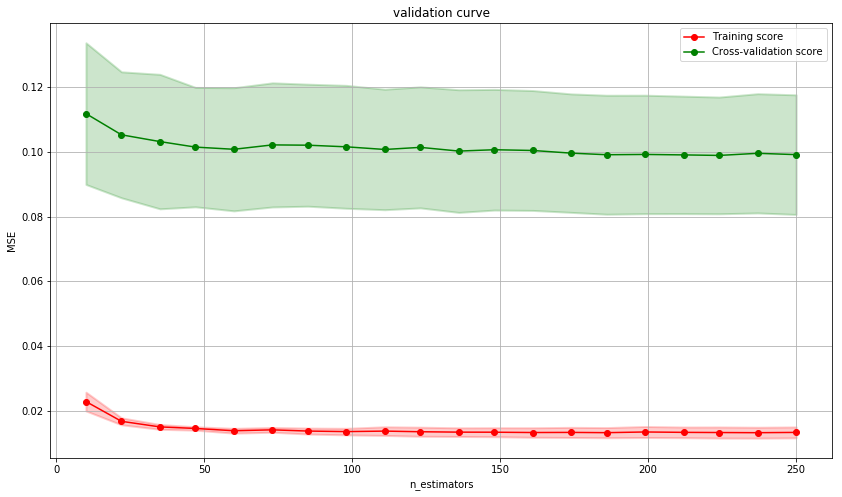

Best n_estimators: 224
The sglobal  (MSE) -0.002732621258012216
The real global  (MSE) 0.9972711089529328


C:\Users\Patrizio\.conda\envs\AC36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of the errors')

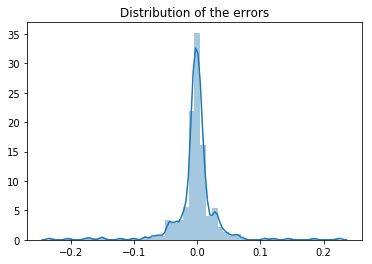

In [308]:
## apply standard scaler 
scaler=StandardScaler()
X_scaled= scaler.fit_transform(df_onehotencoded2)


X_train, X_test, y_train, y_test = train_test_split(X_scaled,yy, test_size = 0.2, random_state = 23)
#X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = SEED)

print('Dimensions of training set: {}'.format(X_train.shape))
print('Dimensions of testing set: {}'.format(X_test.shape))


# Define pipeline
estimators = []
estimators.append(('rf_reg', RandomForestRegressor()))

rf_pipe = Pipeline(estimators)
rf_pipe.set_params(rf_reg__random_state = SEED)

# CV schema
cv_schema = KFold(n_splits = N_SPLITS, random_state = SEED)

# Tune model against a single hyper parameter
tuning_param = 'rf_reg__n_estimators'

tuning_param_range = [int(i) for i in np.linspace(10.0, 250.0, 20)]

# Tune hyper parameter using validation curve
train_scores_val, cv_scores_val = validation_curve(
    rf_pipe, X_train, y_train, param_name = tuning_param, param_range = tuning_param_range,
    cv = cv_schema, scoring = SCORE, n_jobs = -1)

# Draw validation curve   
plot_validation_curve(-train_scores_val, -cv_scores_val, tuning_param_range, scale = 'lin', 
                      title = 'validation curve', y_label = 'MSE', x_label = 'n_estimators')

# Obtain the best value of the hyper parameter
best_param_val = tuning_param_range[np.argmin(np.mean(-cv_scores_val, axis=1))]
print('Best n_estimators: {}'.format(best_param_val))


#FITTHE MODEL WITH BEST PARAMETERS 
rfr = RandomForestRegressor( n_estimators=best_param_val,random_state=False, verbose=False)
rfr.fit(X_train,y_train)

yhat=rfr.predict(X_test)


The sglobal  (MSE) 12.70656646677726 % on exponential values


Text(0.5, 1.0, 'Distribution of the errors')

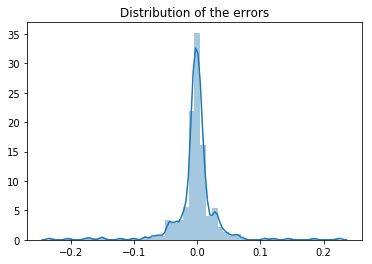

In [309]:
print('The sglobal  (MSE)',compute_exponential_score(y_test,yhat),'% on exponential values')
#VISUALISE ERRORS 
sns.distplot((y_test-yhat)/y_test)
plt.title('Distribution of the errors')


In [310]:
importance=pd.DataFrame()
importance['Name']=df_onehotencoded2.columns
importance['Value']=rfr.feature_importances_


importance.sort_values(by='Value',ascending=False,inplace=True)

importance.head(15)

,Name,Value
43,reviews_per_month,0.574941
20,minimum_nights_avg_ntm,0.146479
11,price,0.120924
17,maximum_minimum_nights,0.048822
16,minimum_minimum_nights,0.038022
14,minimum_nights_x,0.035916
0,host_id,0.002492
6,longitude,0.002235
44,distance,0.001984
5,latitude,0.001854


In [ ]:
importance[importance.Name == 'cluster']

# Discussion on the results 

- in geneva more than 2000 apartments are rented on airbnb every year. 
- The most influencial parameters for detemining the revenues are the reviews, as stated in the AIRBNB the number of reviews tells if a renter location is good and y the owned might get ot of money out of it.
- Adding the cluster information to the model, based on the caracteristics onthe neighborhood, does not increase accuracy but it risks to lower it adding noise in the model. The reason might be that taking information for quite a big area might not be representative for thesingle points.
- another reason might be that geneva is a geographically small canton and differences are quite small among different municipalities in the canton. 

Further exploration might be needed to :
- compare results from geneva with other cities in the world or in Switzerland 
- forecast a price in absence of reviews 
- get to some information about the photos of the houses
- include information from the text from reviews a simple example can be retrieved. 


This work is intended to be open source and is based on publicly available data. 

### Other points: One might add the textual features to improve the results of the regression

In [ ]:
example = ge_reviews[ge_reviews.listing_id==42515].comments

In [ ]:
example.shape

In [ ]:

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(example))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
